In [1]:
%matplotlib inline

# Ultrasound imaging simulation

Use NDK to simulate the image captured by an ultrasound transducer.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm.notebook

import neurotechdevkit as ndk
from neurotechdevkit.sources import PhasedArraySource2D
from neurotechdevkit.scenarios.built_in import Scenario3

# Imaging modules
from neurotechdevkit.imaging import demodulate, beamform, util

In [3]:
# Scenario parameters
SPEED_OF_SOUND_WATER = 1500  # meters per second

# Plane-wave pulse parameters
TONE_CENTER_FREQUENCY = 0.5e6  # Hz
TILT_ANGLES_DEG = np.linspace(start=-10, stop=10, endpoint=True, num=5)  # Plane-wave pulses

# Phased array transducer parameters
ARRAY_PITCH=300e-6
ARRAY_ELEMENT_WIDTH=270e-6
ARRAY_NUM_ELEMENTS=128
TRANSDUCER_6DB_PULSE_ECHO_FRACTIONAL_BANDWIDTH = 0.5  # transmit/receive frequency bandwidth as a fraction of center frequency

# Simulation parameters - choosing somewhat arbitrary values
SAMPLING_POINTS_PER_PERIOD = 24

RANDOM_SEED = 58295  # Use if we need the specific function to be deterministic
rng = np.random.default_rng(seed=58295)  # Use if we only need the notebook to be deterministic

## Define a scenario.

Ultrasound imaging measures the scattering of sound waves, which occur due to changes in acoustic impedance (speed and density). In normal tissue, these changes occur across different scales. Large tissue boundaries cause specular scattering, and microscopic heterogeneities cause diffuse scattering. 

To mimic these properties, we create ultrasound phantoms that are similarly heterogenous across different scales. Their bulk acoustic impedance differs from the background medium (water), and their within-phantom impednances also vary at small scales.

For the transducer, we choose a phased array that can both steer ultrasonic waves and record independently at multiple elements.

We visualize the scenario layout with the material masks and then visualize the acoustic properties that affect wave scattering and propagation.

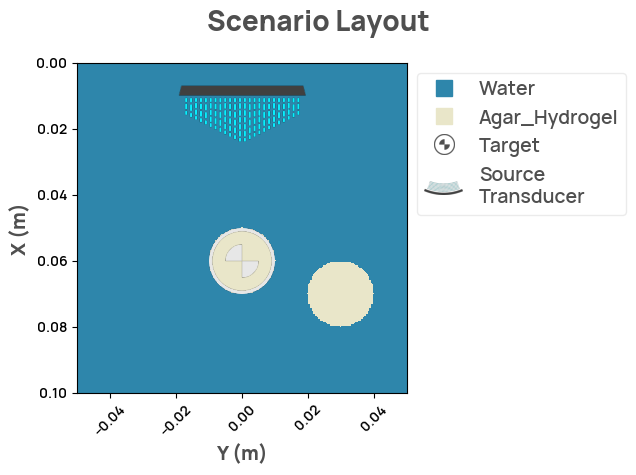

In [4]:
def create_scenario(tilt_angle: float = 0.0) -> Scenario3:
    """Helper function to initialize scenario with different tilt angles."""
    scenario = Scenario3()
    scenario.center_frequency = TONE_CENTER_FREQUENCY
    source_position = np.array([0.01, 0.0])
    unit_direction = np.array([1.0, 0.0])

    source = PhasedArraySource2D(
        position=source_position,
        direction=unit_direction,
        num_elements=ARRAY_NUM_ELEMENTS,
        num_points=ARRAY_NUM_ELEMENTS * 4,
        tilt_angle=tilt_angle,
        # Unfocused source for plane-wave
        focal_length=np.inf,
        pitch=ARRAY_PITCH,
        element_width=ARRAY_ELEMENT_WIDTH,
    )
    scenario.sources = [source]
    # Place point receivers at the transducer sources
    scenario.receiver_coords = source.element_positions
    scenario.make_grid()
    scenario.compile_problem()
    return scenario

scenario = create_scenario()
scenario.render_layout()

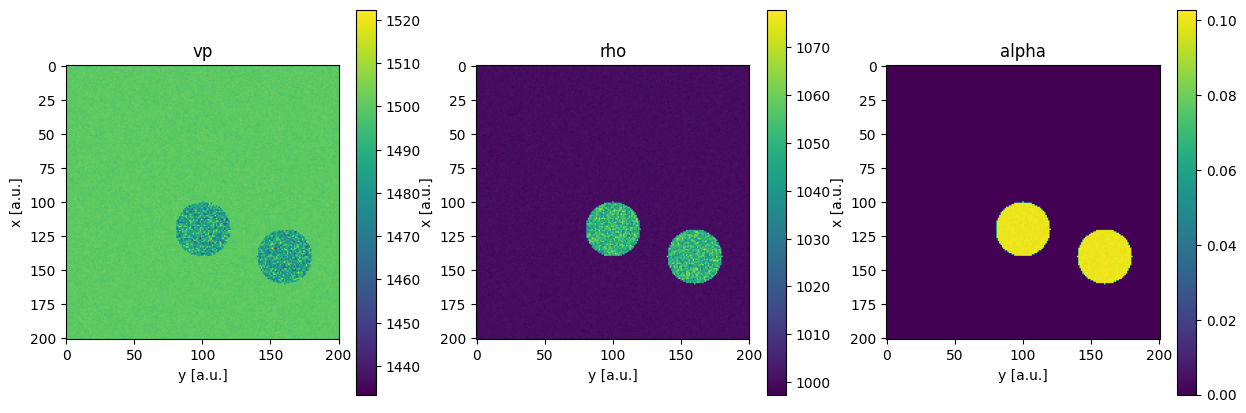

In [5]:
# Plot the relevant material metrics
# vp - speed of sound
# rho - density
# alpha - attenuation
fig,axs = plt.subplots(1,3,figsize=(15,5))

for idx, attribute in enumerate(["vp", "rho", "alpha"]):
    im = axs[idx].imshow(getattr(scenario.problem.medium, attribute).data)
    plt.colorbar(im, ax=axs[idx])
    axs[idx].set_title(attribute)
    axs[idx].set_xlabel("y [a.u.]")
    axs[idx].set_ylabel("x [a.u.]")

# Transmit ultrasonic plane waves
We run multiple NDK simulations, each sending an ultrasonic plane wave at the phantoms at different angles.
Each echo provides a low-resolution image of the target object. By summing the complex-valued images, the low-resolution image's phases cancel out and create a higher-resolution "compound" image.

By the way, I'm using the terms pulse/echo/plane-wave somewhat interchangeably, but more specifically pulse=`transmitted ultrasonic wave`, echo=`the sensor signals received from a given pulse`, and plane-wave=`a specific kind of pulse where the wavefront is a plane/line`

Let's first visualize the plane wave at the default tilt angle (0&deg;).

Estimated time to complete simulation: 48 seconds. Memory required is 8.112811402326496 GB (available 68.719476736 GB). These values are approximated.
Default Devito configuration:
	 * autotuning=off
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp
(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 0.499-0.503 MHz
(ShotID 0) Spatial grid spacing (0.500 mm | 5.758 PPW) is below dispersion limit (0.576 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.083 μs | 25%) is below OT2 limit (0.147 μs)
(ShotID 0) Selected undersampling level 4
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 0.0005, h_y: 0.0005}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 4.91 s
  * lowering.Clusters: 2.58 s (52.6 %)
     * specializing.Clusters: 1.49 s (30.4 %)
  * lowering.Expressions: 1.26 s (25.7 %)
Flops reduction after symbolic optimi

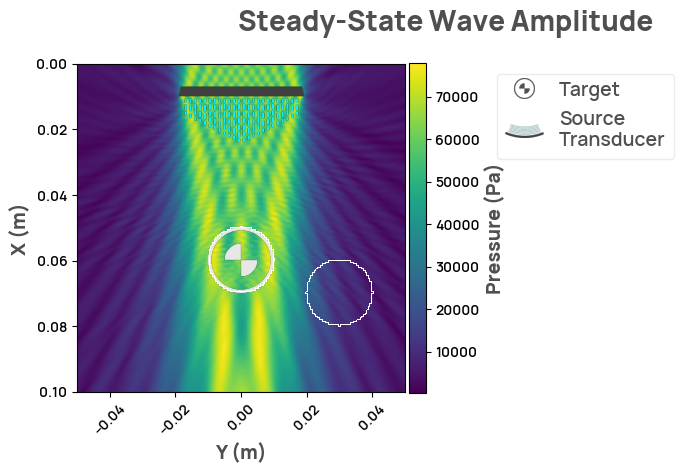

In [6]:
result = create_scenario().simulate_steady_state()
result.render_steady_state_amplitudes()

We can see that the plane wave sonicates a large area of the medium, including the center phantom and (to a lesser extent) the phantom on the right.

# Multi-plane-wave transmission
Now, let's send several plane waves from the transducer and measure the reflected/scattered acoustic waves.
We can then compound the different plane waves to improve the spatial resolution.

In [7]:
# Helper functions: simulate long enough for ultrasound scattering reflection
def calc_simulation_time(scenario: Scenario3):
    simulation_time = ndk.scenarios._time.select_simulation_time_for_pulsed(
        grid=scenario.grid,
        materials=scenario.materials,
        delay=ndk.scenarios._time.find_largest_delay_in_sources(scenario.sources),
    )
    # Run pulse for twice the standard simulation time to allow for reflections
    return 2 * simulation_time

In [8]:
# Send several plane waves from the transducer and measure the reflected/scattered acoustic waves
# We can then compound the different plane waves to improve the spatial resolution

results = [None] * len(TILT_ANGLES_DEG)
# keep track of the tx delays used
element_delays_list = [None] * len(TILT_ANGLES_DEG)

for idx, tilt_angle in enumerate(tqdm.notebook.tqdm(TILT_ANGLES_DEG, desc="Simulating pulses", unit="pulse")):
    # Current limitation of NDK: need to re-generate scenario to simulate a new pulse
    # https://github.com/agencyenterprise/neurotechdevkit/issues/108
    scenario = create_scenario(tilt_angle=tilt_angle)
    # Get the element delays (set by the tilt angle)
    element_delays_list[idx] = scenario.sources[0].element_delays
    results[idx] = scenario.simulate_pulse(
        points_per_period=SAMPLING_POINTS_PER_PERIOD,
        simulation_time=calc_simulation_time(scenario),
    )

Simulating pulses:   0%|          | 0/5 [00:00<?, ?pulse/s]

Estimated time to complete simulation: 2 minutes. Memory required is 9.04987804400852 GB (available 68.719476736 GB). These values are approximated.
Default Devito configuration:
	 * autotuning=off
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp
(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 0.256-0.732 MHz
(ShotID 0) Spatial grid spacing (0.500 mm | 3.952 PPW) is higher than dispersion limit (0.395 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.083 μs | 25%) is below OT2 limit (0.148 μs)
(ShotID 0) Selected undersampling level 4
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 0.0005, h_y: 0.0005}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 4.89 s
  * lowering.Clusters: 2.74 s (56.1 %)
     * specializing.Clusters: 1.62 s (33.2 %)
  * lowering.Expressions: 1.13 s (23.2 %)
Flops reduction after symbolic op

## Visualizing received (simulated) signals

In a real imaging situation, we usually only have access to the RF signals measured at the ultrasound sensor elements; we don't know what's in the grid and can't access the full wavefield.

In [9]:
# The receivers at N sensor elements give us data traces of [N, num_fast_time_samples]
assert results[0].traces.data.shape == (
    ARRAY_NUM_ELEMENTS,
    len(results[0].traces.time.grid)
)
time_steps = [result.traces.time.step for result in results]
np.testing.assert_array_equal(time_steps[0], time_steps)
freq_sampling = TONE_CENTER_FREQUENCY * SAMPLING_POINTS_PER_PERIOD
assert np.allclose(time_steps[0], 1 / freq_sampling)

print("Traces shape:", results[0].traces.data.shape)
print("Time grid:", results[0].traces.time.grid)
print("Sampling frequency [Hz]: {:.2e}".format(freq_sampling))

Traces shape: (128, 2393)
Time grid: [0.0000000e+00 8.3333333e-08 1.6666667e-07 ... 1.9916666e-04 1.9925000e-04
 1.9933333e-04]
Sampling frequency [Hz]: 1.20e+07


In [10]:
# Pad RF signals to longest length, in case they are not all the same length
rf_signal_lengths = [len(result.traces.time.grid) for result in results]
rf_signal_max_len = max(rf_signal_lengths)
rf_signal_max_len_idx = np.argmax(rf_signal_lengths)
time = results[rf_signal_max_len_idx].traces.time.grid

# Shape: [num_fast_time_samples, num_elements, num_pulses]
rf_signals = np.zeros(
    (rf_signal_max_len, ARRAY_NUM_ELEMENTS, len(results)),
    dtype=float,
)
for pulse_idx, result in enumerate(results):
    rf_signals[:rf_signal_lengths[pulse_idx], :, pulse_idx] = result.traces.data.T

In [11]:
# The data at the beginning of each pulse simply contains the transmitted pulse,
# so let's remove it from the raw-data visualizations to prevent it from overwhelming the reflected image.
extra_buffer_fraction = 0.05
array_element_positions = scenario.sources[0].element_positions
distance = np.linalg.norm(array_element_positions.max() - array_element_positions.min())

for pulse_idx, element_delays in enumerate(element_delays_list):
    max_time_delay = element_delays.max()
    last_invalid_time = (1 + extra_buffer_fraction) * (distance / SPEED_OF_SOUND_WATER + max_time_delay)
    valid_time_mask = time > last_invalid_time

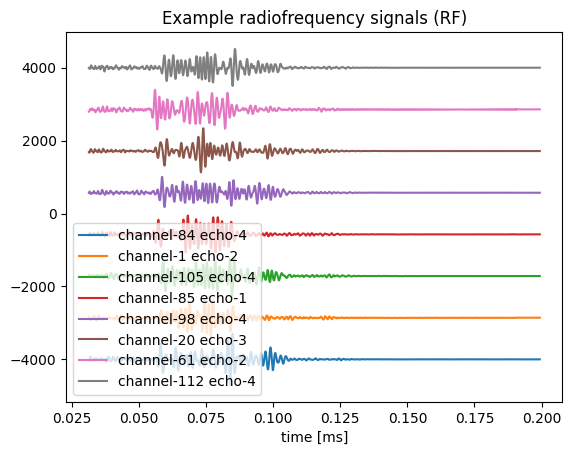

In [12]:
NUM_VISUALIZE = 8
channel_idxs = rng.integers(ARRAY_NUM_ELEMENTS, size=NUM_VISUALIZE)
pulse_idxs = rng.integers(len(TILT_ANGLES_DEG), size=NUM_VISUALIZE)

rf_signal_visualize = rf_signals[:, channel_idxs, pulse_idxs]

# Plot with some offsets
CHANNEL_OFFSET = 1000
_ = plt.plot(
    time[valid_time_mask] * 1e3,
    rf_signal_visualize[valid_time_mask] + np.linspace(-0.5, 0.5, num=NUM_VISUALIZE, endpoint=True) * NUM_VISUALIZE * CHANNEL_OFFSET,
    label=[f"channel-{channel_idx} echo-{echo_idx}" for (channel_idx, echo_idx) in zip(channel_idxs, pulse_idxs)],
)
_ = plt.legend()
_ = plt.title("Example radiofrequency signals (RF)")
_ = plt.xlabel("time [ms]")

Plotting across elements (for a single shot) shows the typical hyperbolas for each scatterer (object). 

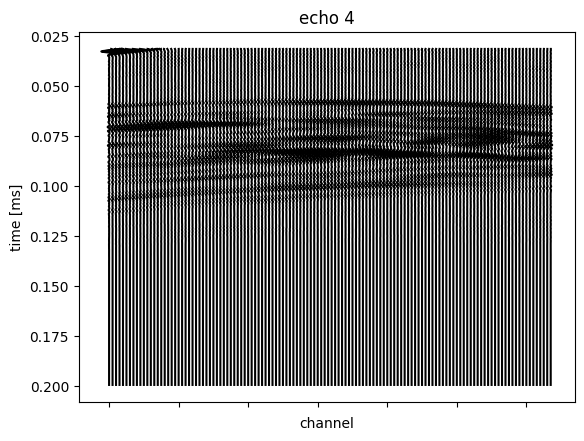

In [13]:
pulse_idx = rng.integers(len(TILT_ANGLES_DEG))

fig, ax = plt.subplots()
ax.plot(
    rf_signals[valid_time_mask, :, pulse_idx] + np.arange(ARRAY_NUM_ELEMENTS) * CHANNEL_OFFSET,
    time[valid_time_mask] * 1000,
    color='k',
)
ax.set_title(f"echo {pulse_idx}")
ax.set_xticklabels([])  # We added values for offset, so values don't mean anything
ax.set_ylabel("time [ms]")
ax.set_xlabel("channel")
ax.invert_yaxis()

This helps to visualize the slight time-offsets of each array element in receiving the echoes.

## Image reconstruction

In multi-plane-wave imaging, each pulse-echo image is constructed separately, then added together.

Similar to the focused-pulse `109-ultrasound-imaging-scanline.ipynb` notebook, this notebook demodulates the RF signals to I/Q and then beamforms to create each pulse-echo frame.

In [14]:
iq_signals, _ = demodulate.demodulate_rf_to_iq(
    rf_signals,
    freq_sampling,
    freq_carrier=TONE_CENTER_FREQUENCY,
    bandwidth=TRANSDUCER_6DB_PULSE_ECHO_FRACTIONAL_BANDWIDTH,
)

assert iq_signals.shape == rf_signals.shape

In [15]:
# Beam-form I/Q signals into an image

assert len(scenario.sources) == 1
source = scenario.sources[0]
assert isinstance(source, ndk.sources.PhasedArraySource)
pitch = source.pitch
width = source.element_width
empirical_pitch = np.linalg.norm(np.diff(results[0].shot.receiver_coordinates, axis=0), axis=1)
np.testing.assert_allclose(empirical_pitch, pitch, rtol=1e-2)

# Generate an image at the scenario grid
# NOTE: .mesh uses different x/y space
x_mesh, y_mesh = results[0].shot.grid.space.mesh

# Switch to imaging convention: x for parallel-to-array, z for depth
imaging_x_mesh = y_mesh + scenario.origin[1]
imaging_z_mesh = x_mesh + scenario.origin[0]

iq_signals_beamformed_list = []
for idx, tilt_angle in enumerate(TILT_ANGLES_DEG):
    iq_signals_beamformed = beamform.beamform_delay_and_sum(
        iq_signals[:, :, idx],
        x=imaging_x_mesh,
        z=imaging_z_mesh,
        pitch=pitch,
        tx_delays=element_delays_list[idx],
        freq_sampling=freq_sampling,
        freq_carrier=TONE_CENTER_FREQUENCY,
        f_number=None,
        width=width,
        bandwidth=TRANSDUCER_6DB_PULSE_ECHO_FRACTIONAL_BANDWIDTH,
        speed_sound=SPEED_OF_SOUND_WATER,  # water
    )
    iq_signals_beamformed_list.append(iq_signals_beamformed)

iq_signals_beamformed_compound = np.stack(iq_signals_beamformed_list, axis=-1)
iq_signals_beamformed_compound.shape

(201, 201, 5)

## Visualize reconstructed image

In [16]:
def plot_ultrasound_image(x_mesh, z_mesh, iq_signals_bf, db=40):
    plt.pcolormesh(
        x_mesh,
        z_mesh,
        util.log_compress(iq_signals_bf, db),
        cmap='gray',
    )
    cbar = plt.colorbar(ticks=[0, 1])
    cbar.ax.set_yticklabels([f"-{db} dB", "0 dB"])  # horizontal colorbar

    plt.axis('equal')
    plt.gca().invert_yaxis()  # Invert the y-axis to flip the image vertically
    plt.title('Log-compressed image')
    plt.xlabel('[m]')
    plt.ylabel('[m]')

In [17]:
DB_VIS = 30

Text(0.5, 1.0, 'Single pulse-echo image')

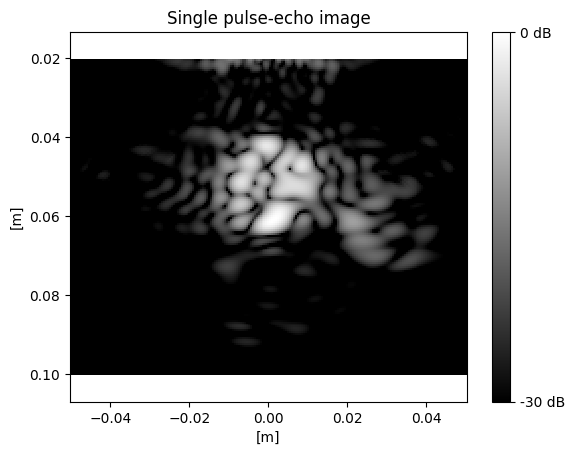

In [18]:
mask = (imaging_z_mesh > 0.02).all(axis=1)

plot_ultrasound_image(
    imaging_x_mesh[mask],
    imaging_z_mesh[mask],
    iq_signals_beamformed_compound[mask, :, len(TILT_ANGLES_DEG) // 2],
    db=DB_VIS
)
plt.title("Single pulse-echo image")

A single plane-wave pulse is unfocused, so the image is blurry. On the other hand, it sonicates a larger area than a focused ultrasound beam (a.k.a. "scan line"), so it includes both the center circle and the right circle (blurrily).

Text(0.5, 1.0, 'Compound image')

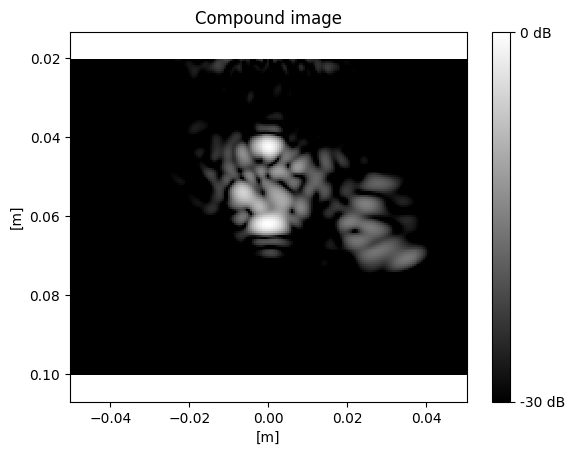

In [19]:
plot_ultrasound_image(
    imaging_x_mesh[mask],
    imaging_z_mesh[mask],
    iq_signals_beamformed_compound[mask].sum(axis=-1),
    db=DB_VIS
)
plt.title("Compound image")

Compounding multiple plane waves improves the image focus.

The speckles in the image are a normal part of B-mode imaging.
Additionally, the phantom on the right experiences a slight "shadow," because not all of the plane waves reach it. If we increase the width of the array so that the plane waves are wider, we would get better coverage of the phantom on the right.